# **Image classification on Caltech 101 dataset**

---

## **Contents**

- Importing dataset from Kaggle
- Splitting into train, val and test sets
- Passing directly through a pre-trained model
  - Setting the data generators
  - Building the model
- Fine tuning
  - Setting the data generators
  - Building the model
- Further fine tuning (training the final conv base)
- Evaluating on test data
  - Saving model in Google Drive
- Conclusion

---

In [33]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator

---

## **Importing dataset from kaggle**

The dataset is taken from kaggle (https://www.kaggle.com/athota1/caltech101). To import it locally, first download your Kaggle API token, run the following cells, and upload that file when prompted.

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()      # Choose the kaggle.json file downloaded above

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raahat98","key":"36600a230b41d0fe5051705bd066f73c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d athota1/caltech101

100% 262M/262M [00:02<00:00, 89.9MB/s]



In [ ]:
! unzip caltech101.zip

In [8]:
DATASET_DIR = './101_ObjectCategories/'

---

## **Splitting into train, val and test sets**

- Training: 0.7
- Validation: 0.2
- Testing: 0.1

In [12]:
folder_names = []
folder_names = [f for f in sorted(os.listdir(DATASET_DIR))]

In [15]:
category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}

total_images = 0

for i, category in enumerate(folder_names):
    category_dict[i] = category
    
    folder_path = DATASET_DIR + '/' + category
    image_names = [img for img in sorted(os.listdir(folder_path))]
    
    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names
    
    # print('%s: %d' %(category, images_per_category_dict[i]))
    total_images += images_per_category_dict[i]

In [9]:
base_path = './split_dataset'

train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')

In [10]:
base_path = './split_dataset'
os.mkdir(base_path)

train_dir = os.path.join(base_path, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_path, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_path, 'test')
os.mkdir(test_dir)

In [13]:
for directory in [train_dir, validation_dir, test_dir]:
  for category in folder_names:
      os.mkdir(os.path.join(directory, category))

In [18]:
 total_train = 0
total_validation = 0
total_test = 0

total_train_2 = 0
total_validation_2 = 0
total_test_2 = 0


for i, category in enumerate(folder_names):
  train_number = int(0.7 * images_per_category_dict[i])
  validation_number = int(0.2 * images_per_category_dict[i])
  test_number = images_per_category_dict[i] - train_number - validation_number 
  
  total_train += train_number
  total_validation += validation_number
  total_test += test_number
  

  fnames = category_images_path_dict[i][:train_number]
  for fname in fnames:
    src = os.path.join(DATASET_DIR, category, fname)
    dst = os.path.join(train_dir, category, fname)
    shutil.copyfile(src, dst)
      
  total_train_2 += len(fnames)
      

  fnames = category_images_path_dict[i][train_number:train_number + validation_number]
  for fname in fnames:
    src = os.path.join(DATASET_DIR, category, fname)
    dst = os.path.join(validation_dir, category, fname)
    shutil.copyfile(src, dst)
      
  total_validation_2 += len(fnames)
  

  fnames = category_images_path_dict[i][train_number + validation_number:]
  for fname in fnames:
    src = os.path.join(DATASET_DIR, category, fname)
    dst = os.path.join(test_dir, category, fname)
    shutil.copyfile(src, dst)
      
  total_test_2 += len(fnames)

In [19]:
print('Correct train split: ', total_train == total_train_2)
print('Correct validation split: ', total_validation == total_validation_2)
print('Correct test split: ', total_test == total_test_2)
print()
print('Number of training images: ', total_train)
print('Number of validation images: ', total_validation)
print('Number of test images: ', total_test)
print()
print('Real percentage of training images: ', total_train / total_images)
print('Real percentage of validation images: ', total_validation / total_images)
print('Real percentage of test images: ', total_test / total_images)

Correct train split:  True
Correct validation split:  True
Correct test split:  True

Number of training images:  6353
Number of validation images:  1788
Number of test images:  1004

Real percentage of training images:  0.6946965554948059
Real percentage of validation images:  0.19551667577911427
Real percentage of test images:  0.10978676872607983


---

## **Passing directly through a pre-trained model**

VGG-16 model pre-trained on ImageNet

In [20]:
#conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (197, 197, 3))
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Setting the data generators

In [22]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [23]:
def extract_features(directory, sample_count):

  features = np.zeros(shape = (sample_count, 4, 4, 512))
  labels = np.zeros(shape = (sample_count, 102))

  generator = datagen.flow_from_directory(directory, 
                                          target_size = (150, 150),
                                          batch_size = batch_size,
                                          class_mode = 'categorical'
                                          )
  

  i = 0
  for inputs_batch, labels_batch in generator:

    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch

    i += 1
    if i * batch_size >= sample_count:
      break


  return features, labels

In [26]:
train_features, train_labels = extract_features(train_dir, 6353)
validation_features, validation_labels = extract_features(validation_dir, 1788)
test_features, test_labels = extract_features(test_dir, 1003)

Found 6353 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.
Found 1003 images belonging to 102 classes.


In [27]:
train_features = np.reshape(train_features, (6353, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1788, 4 * 4 * 512))
test_features = np.reshape(test_features, (1003, 4 * 4 * 512))

### Building the model

In [28]:
model = models.Sequential()
model.add(layers.Dense(512, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(102, activation = 'softmax'))

In [29]:
model.compile(optimizer = optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['acc']
              )

In [30]:
history = model.fit(train_features, train_labels, 
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels)
                    )

Epoch 1/30
318/318 [==============================] - 8s 5ms/step - loss: 2.9802 - acc: 0.3934 - val_loss: 1.2686 - val_acc: 0.6874
Epoch 2/30
318/318 [==============================] - 1s 4ms/step - loss: 1.2321 - acc: 0.6814 - val_loss: 0.8585 - val_acc: 0.7808
Epoch 3/30
318/318 [==============================] - 1s 4ms/step - loss: 0.7852 - acc: 0.7858 - val_loss: 0.7955 - val_acc: 0.7947
Epoch 4/30
318/318 [==============================] - 1s 4ms/step - loss: 0.5954 - acc: 0.8287 - val_loss: 0.7129 - val_acc: 0.8065
Epoch 5/30
318/318 [==============================] - 1s 4ms/step - loss: 0.4732 - acc: 0.8632 - val_loss: 0.7387 - val_acc: 0.8059
Epoch 6/30
318/318 [==============================] - 1s 4ms/step - loss: 0.3896 - acc: 0.8834 - val_loss: 0.7031 - val_acc: 0.8210
Epoch 7/30
318/318 [==============================] - 1s 4ms/step - loss: 0.3045 - acc: 0.9098 - val_loss: 0.6600 - val_acc: 0.8283
Epoch 8/30
318/318 [==============================] - 1s 4ms/step - loss: 0.

In [34]:
def plot_training_graph(hist_obj):
  acc = hist_obj.history['acc']
  val_acc = hist_obj.history['val_acc']
  loss = hist_obj.history['loss']
  val_loss = hist_obj.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label = 'Training acc')
  plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()


  plt.plot(epochs, loss, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

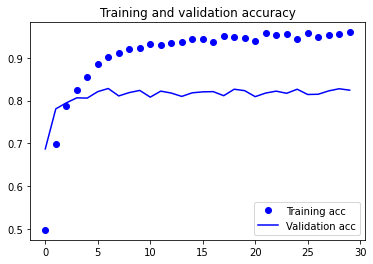

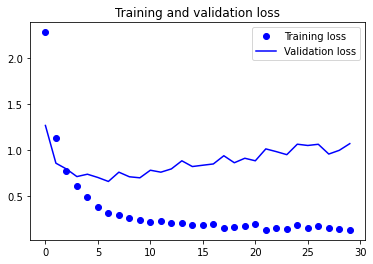

In [35]:
plot_training_graph(history)

---

## **Fine tuning**

### Setting the data generators

In [36]:
# Data Augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                   )

In [37]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [38]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'categorical'
                                                    )

Found 6353 images belonging to 102 classes.


In [39]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = 'categorical'
                                                        )

Found 1788 images belonging to 102 classes.


### Building the model

In [40]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(102, activation = 'softmax'))

In [41]:
conv_base.trainable = False

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               52326     
Total params: 18,961,830
Trainable params: 4,247,142
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics = ['acc']
              )

In [44]:
history = model.fit(train_generator,
                    steps_per_epoch = 300,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 80,
                    verbose = 2
                    )

# steps_per_epoch = 6353/20

Epoch 1/30
300/300 - 42s - loss: 2.4426 - acc: 0.4617 - val_loss: 1.4260 - val_acc: 0.6544
Epoch 2/30
300/300 - 40s - loss: 1.3914 - acc: 0.6471 - val_loss: 1.1533 - val_acc: 0.7063
Epoch 3/30
300/300 - 40s - loss: 1.1850 - acc: 0.6851 - val_loss: 0.9564 - val_acc: 0.7544
Epoch 4/30
300/300 - 40s - loss: 1.0243 - acc: 0.7210 - val_loss: 0.9885 - val_acc: 0.7406
Epoch 5/30
300/300 - 40s - loss: 0.9400 - acc: 0.7395 - val_loss: 0.8918 - val_acc: 0.7606
Epoch 6/30
300/300 - 40s - loss: 0.8614 - acc: 0.7500 - val_loss: 0.8517 - val_acc: 0.7825
Epoch 7/30
300/300 - 40s - loss: 0.7917 - acc: 0.7791 - val_loss: 0.9228 - val_acc: 0.7656
Epoch 8/30
300/300 - 40s - loss: 0.7647 - acc: 0.7872 - val_loss: 0.8863 - val_acc: 0.7812
Epoch 9/30
300/300 - 40s - loss: 0.7060 - acc: 0.7996 - val_loss: 0.8419 - val_acc: 0.7850
Epoch 10/30
300/300 - 40s - loss: 0.6850 - acc: 0.7958 - val_loss: 0.9346 - val_acc: 0.7606
Epoch 11/30
300/300 - 41s - loss: 0.6633 - acc: 0.8108 - val_loss: 0.9318 - val_acc: 0.76

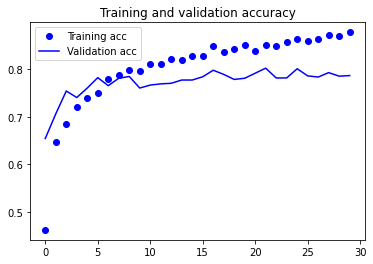

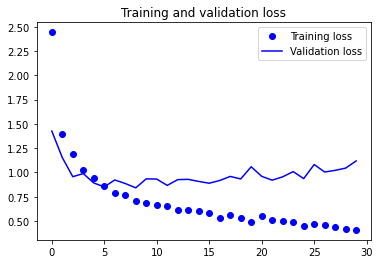

In [45]:
plot_training_graph(history)

---

## **Further fine tuning (training the final conv base)**

In [46]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True

  if set_trainable:
    layer.trainable = True
    
  else:
    layer.trainable = False

In [47]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 1e-5),
              metrics = ['acc']
              )

In [49]:
history = model.fit(train_generator,
                    steps_per_epoch = 300,
                    epochs = 30,
                    validation_data = validation_generator, 
                    validation_steps = 80
                    )

Epoch 1/30
300/300 [==============================] - 47s 146ms/step - loss: 0.3503 - acc: 0.8939 - val_loss: 0.9513 - val_acc: 0.8062
Epoch 2/30
300/300 [==============================] - 43s 144ms/step - loss: 0.3057 - acc: 0.9067 - val_loss: 0.9832 - val_acc: 0.8075
Epoch 3/30
300/300 [==============================] - 43s 143ms/step - loss: 0.2832 - acc: 0.9171 - val_loss: 1.0109 - val_acc: 0.8062
Epoch 4/30
300/300 [==============================] - 43s 144ms/step - loss: 0.2467 - acc: 0.9249 - val_loss: 0.9871 - val_acc: 0.8056
Epoch 5/30
300/300 [==============================] - 43s 144ms/step - loss: 0.2163 - acc: 0.9351 - val_loss: 0.9157 - val_acc: 0.8144
Epoch 6/30
300/300 [==============================] - 43s 143ms/step - loss: 0.2063 - acc: 0.9383 - val_loss: 0.9410 - val_acc: 0.8169
Epoch 7/30
300/300 [==============================] - 43s 143ms/step - loss: 0.1870 - acc: 0.9422 - val_loss: 0.8893 - val_acc: 0.8281
Epoch 8/30
300/300 [==============================] - 4

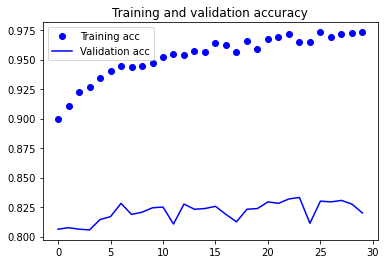

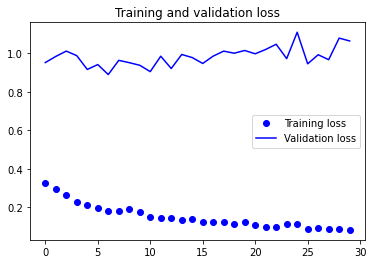

In [50]:
plot_training_graph(history)

---

## **Evaluating on test data**

In [51]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 20,
                                                  class_mode = 'categorical'
                                                  )

Found 1003 images belonging to 102 classes.


In [52]:
test_loss, test_acc = model.evaluate(test_generator, steps = 50)
print('Test acc: {}'.format(test_acc))

50/50 [==============================] - 3s 60ms/step - loss: 0.9917 - acc: 0.8330
Test acc: 0.8330000042915344


### Saving model in Google Drive

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
model_path = 'drive/MyDrive/Caltech 101/clf_1.h5'
model.save(model_path)

---

## **Conclusion**

The validaton accuracy was 82.4% when using pre-trained weights directly. It changed to 78.7% when training our own dense layers, and 83.3% when unfreezing and training the final concolution block. The test accuracy we were able to achieve is 83.3%. To improve it further, more data would be required.

